# Deindexing reason in the Brazil SciELO collection

On the notebook regarding the number of indexed/deindexed/active journals,
we weren't able to distinguish between a *renamed* and a *deceased* journal.
Here the goal is to distinguish between these
and to get more information about the suspending reason,
limited to a single collection: `scl` (Brazil).

In [1]:
def fix_python37_runtime_error_bug(func):
    """
    On Python 3.7.0, the "next" built-in
    no longer propagates the StopIteration
    when called in a generator function.
    This decorator is a hack to restore this behavior,
    and will probably be no longer necessary
    for running the code in this notebook.
    """
    import functools
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            yield from func(*args, **kwargs)
        except RuntimeError as exc:
            if isinstance(exc.__cause__, StopIteration):
                return
            raise
    return wrapper

## Using the ArticleMeta API

Using the ArticleMeta API,
we can get the actual status of every journal in any collection,
as well as its history.
In order to get the renamed entries,
it has an information that the reports don't have:
the previous/next titles of a journal.

Let's use it:

In [2]:
from articlemeta.client import RestfulClient

In [3]:
# Soon this patch won't be required,
# it's here due to a not-backwards compatible change in Python itself
RestfulClient.journals = fix_python37_runtime_error_bug(RestfulClient.journals)

To get all the journals from the `scl` collection: 

In [4]:
%%time
journals = list(RestfulClient().journals(collection="scl"))

CPU times: user 3.47 s, sys: 655 ms, total: 4.13 s
Wall time: 3min 16s


That's it!
It's *really* slow as it's making a request for each journal.
Without the `collection` parameter,
it would grab every journal in the SciELO network.

In [5]:
len(journals) # scl only

366

### Grabbing the history including the titles

We can get the full history from it as a dataframe,
including some extra fields from properties of the journal objects:

In [6]:
import pandas as pd

In [7]:
histories = pd.DataFrame([history + (journal.current_status,
                                     journal.scielo_issn,
                                     journal.title,
                                     journal.previous_title,
                                     journal.data.get("v710", [{}])[0].get("_", None))
                          for journal in journals
                          for history in journal.status_history],
                         columns=["date", "status", "reason", "current_status",
                                  "issn", "title", "previous_title", "next_title"])
print(histories.shape) # There are more than a row for each journal
histories.head(15)

(457, 8)


,date,status,reason,current_status,issn,title,previous_title,next_title
0,2006-02-08,current,,deceased,1676-5648,RAE eletrônica,None,None
1,2010-12,deceased,,deceased,1676-5648,RAE eletrônica,None,None
2,2004-01-08,current,,deceased,0101-8108,Revista de Psiquiatria do Rio Grande do Sul,None,Trends in Psychiatry and Psychotherapy
3,2012-01,deceased,,deceased,0101-8108,Revista de Psiquiatria do Rio Grande do Sul,None,Trends in Psychiatry and Psychotherapy
4,2000-02-13,current,,suspended,0034-7701,Revista de Antropologia,None,None
5,2008-08,suspended,suspended-by-committee,suspended,0034-7701,Revista de Antropologia,None,None
6,1999-12-16,current,,suspended,0102-261X,Revista Brasileira de Geofísica,None,None
7,2003,suspended,suspended-by-committee,suspended,0102-261X,Revista Brasileira de Geofísica,None,None
8,2008,current,,suspended,0102-261X,Revista Brasileira de Geofísica,None,None
9,2012-06,suspended,suspended-by-committee,suspended,0102-261X,Revista Brasileira de Geofísica,None,None


That's based in the
[Data dictionary of the SciELO's model](https://docplayer.com.br/939603-Bireme-opas-oms-centro-latino-americano-e-do-caribe-de-informacao-em-ciencias-da-saude-metodologia-scielo-dicionario-de-dados-do-modelo-scielo.html),
which states in its section "*4 - TITLE database*"
that `v610` means *previous title* and `v710` means *new title*.
Most names have an alias to avoid direct access to the raw data,
but the *new title* field didn't have an alias
as of the time of writing.

From the above dataset,
we can get the pair of ISSNs regarding each title change.
We'll get both the `previous_title` to `title` matching pairs
and the `title` to `next_title` matching pairs,
removing the duplicates.
That will get all changes
even if they're not completely described
in both entries of a pair.

In [8]:
issn_changes_raw = pd.concat([
    pd.merge(histories[histories["next_title"].notna()], histories,
             how="left", left_on="next_title", right_on="title"),
    pd.merge(histories, histories[histories["previous_title"].notna()],
             how="right", left_on="title", right_on="previous_title"),
])[["current_status_x", "issn_x", "issn_y"]].dropna().drop_duplicates().rename(columns={
    "issn_x": "from",
    "issn_y": "to",
})
print(issn_changes_raw.shape)
issn_changes_raw

(39, 3)


,current_status_x,from,to
0,deceased,0101-8108,2237-6089
2,deceased,1516-9332,1984-8250
4,deceased,0104-5687,2179-6491
8,deceased,0101-8175,1984-4670
10,deceased,0101-3122,2317-1537
12,deceased,2179-6491,2317-1782
14,deceased,0373-5524,1413-7739
18,deceased,0100-4239,0373-5524
22,deceased,0100-7386,1678-5878
26,deceased,0034-7108,1519-6984


There's a single name that appeared as `next_title`
but it's the current title:

In [9]:
histories[histories["issn"] == "2448-2455"]

,date,status,reason,current_status,issn,title,previous_title,next_title
264,2016,current,,current,2448-2455,Journal of Physical Education,Revista da Educação Física / UEM,Journal of Physical Education


Cleaning this is easy:
when a journal is renamed and other ISSN is issued,
the current status of the old entry is `deceased`.

In [10]:
issn_changes = issn_changes_raw \
    [issn_changes_raw["current_status_x"] == "deceased"] \
    [["from", "to"]]
issn_changes.shape

(38, 2)

### Analysing the directed graph of renamed journals' ISSNs with NetworkX

In [11]:
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

We can convert the last dataframe to a directed graph object:

In [12]:
issn_changes_graph = nx.DiGraph(issn_changes.values.tolist())

How many nodes (ISSNs) are there?

In [13]:
len(issn_changes_graph.nodes)

71

Can we partition it as disjoint sets of connected nodes?
How many partitions are there?

In [14]:
connected_nodes = list(nx.connected_components(issn_changes_graph.to_undirected()))
print(len(connected_nodes))
connected_nodes

33


[{'0101-8108', '2237-6089'},
 {'1516-9332', '1984-8250'},
 {'0104-5687', '2179-6491', '2317-1782'},
 {'0101-8175', '1984-4670'},
 {'0101-3122', '2317-1537'},
 {'0100-4239', '0373-5524', '1413-7739', '1679-8759'},
 {'0100-7386', '1678-5878'},
 {'0034-7108', '1519-6984'},
 {'0102-2555', '1517-9702'},
 {'0103-0663', '1517-7491', '1806-8324'},
 {'0103-3131', '1677-0420', '2197-0025'},
 {'1516-8034', '2317-6431'},
 {'0001-3714', '1517-8382'},
 {'0071-1276', '0103-9016'},
 {'0102-3586', '1806-3713'},
 {'0100-4158', '1982-5676'},
 {'0100-8455', '1415-4757'},
 {'0104-7930', '1678-9199'},
 {'1413-9251', '1519-7077'},
 {'0301-8059', '1519-566X'},
 {'0041-8781', '1807-5932'},
 {'1809-4864', '1809-4872'},
 {'0004-2730', '2359-3997'},
 {'1517-3151', '2446-4740'},
 {'0101-9880', '2237-9363'},
 {'1415-5419', '2176-9451'},
 {'0034-7299', '1808-8694'},
 {'1983-3083', '2448-2455'},
 {'0370-4467', '2448-167X'},
 {'1516-8484', '2531-1379'},
 {'0080-2107', '2531-0488'},
 {'0104-8023', '1984-0292'},
 {'1806

In [15]:
len(nx.dfs_tree(issn_changes_graph, "1679-8759"))
# issn_changes_graph.in_degree

1

Each set represents an article that had been renamed:

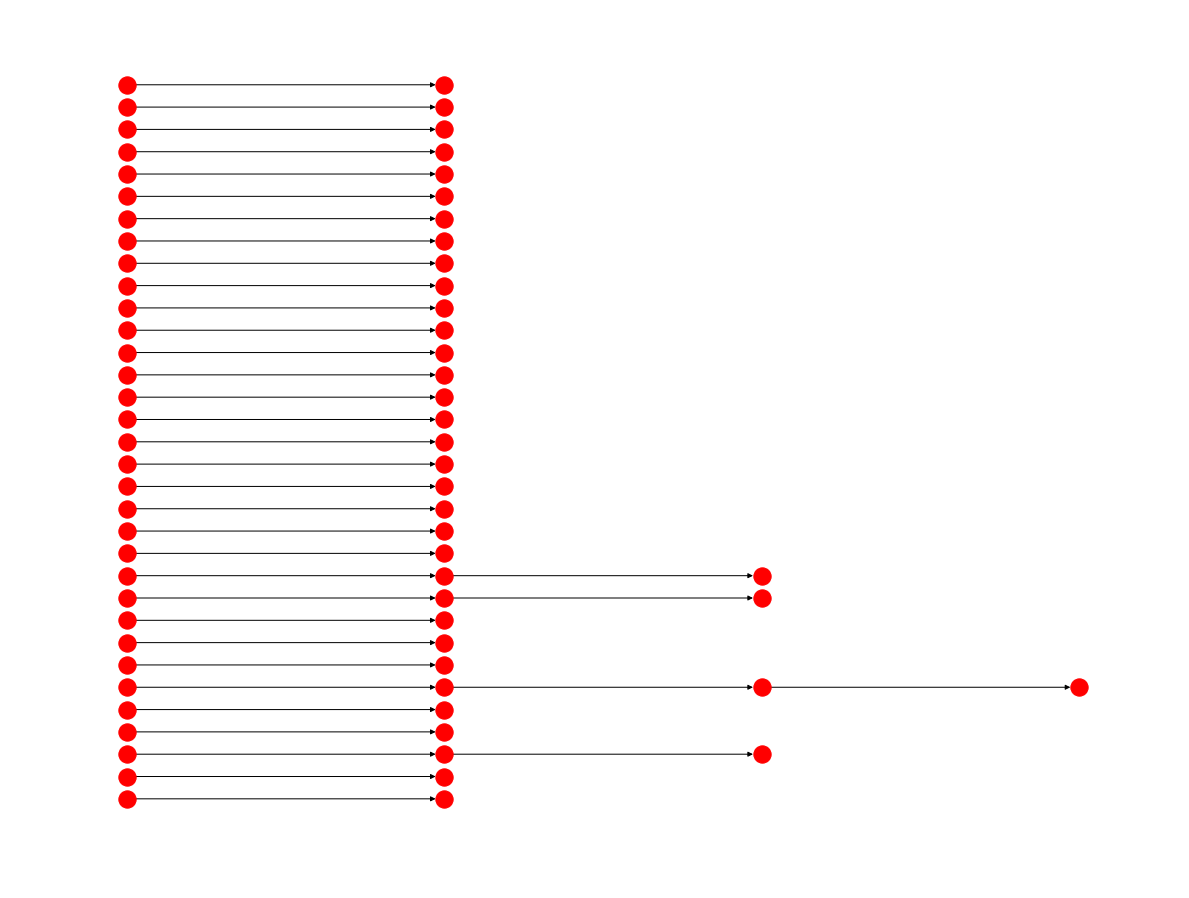

In [16]:
plt.figure(figsize=(16, 12))
nx.draw(issn_changes_graph,
        pos={node: (nidx, pidx)
             for pidx, partition in enumerate(connected_nodes)
             for nidx, node in enumerate(sorted(
                 partition,
                 reverse=True,
                 key=lambda n: len(nx.dfs_tree(issn_changes_graph, n)),
             ))
            },
       )

### Deindexing statistics

This finishes our analysis
of the deindexing reason in the `scl` collection:

In [17]:
full_status_stats = pd.DataFrame(histories
    .sort_values("date")
    .assign(renamed=lambda df: df["issn"].isin(issn_changes["from"]))
    .groupby("issn")
    .agg("last")
    .fillna("")
    .groupby(["current_status", "reason", "renamed"])
    .size()
    .rename("count")
)
full_status_stats

count
current_status reason                 renamed       
current                               False      291
deceased                              False        2
                                      True        38
suspended      not-open-access        False        7
               suspended-by-committee False       26
               suspended-by-editor    False        2

Or, joining the three-layered index into a single string:

,count
status,
current,291
deceased,2
renamed,38
suspended by not open access,7
suspended by committee,26
suspended by editor,2


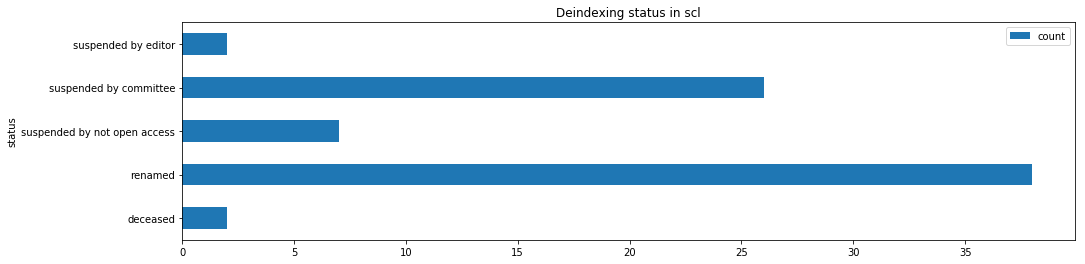

In [18]:
status_stats = full_status_stats.assign(
    status=["renamed" if renamed
                      else reason.replace("not-", "suspended-by-not-")
                                 .replace("-", " ")
                           or current_status
            for current_status, reason, renamed
            in full_status_stats.index.values
    ]
).set_index("status")
status_stats.drop("current").plot.barh(figsize=(16, 4),
                                       title="Deindexing status in scl")
status_stats

## Using the status changes report

We can't get the information regarding the *renamed* entries
using just the CSV reports,
but the remaining information is there.
We can use the `journal.csv`,
but an analysis of it had already been performed
in the notebook that analyzed the number of indexed journals.
As an alternative, let's open the `journal_status_changes.csv`:

In [19]:
journals_status_changes = pd.read_csv("tabs_bra/journals_status_changes.csv")
print(journals_status_changes.shape)
journals_status_changes.columns

(456, 23)


Index(['extraction date', 'study unit', 'collection', 'ISSN SciELO', 'ISSN's',
       'title at SciELO', 'title thematic areas',
       'title is agricultural sciences', 'title is applied social sciences',
       'title is biological sciences', 'title is engineering',
       'title is exact and earth sciences', 'title is health sciences',
       'title is human sciences', 'title is linguistics, letters and arts',
       'title is multidisciplinary', 'title current status',
       'status change date', 'status change year', 'status change month',
       'status change day', 'status changed to', 'status change reason'],
      dtype='object')

It has few columns.
Let's see the first few entries.

In [20]:
journals_status_changes.head().T

,0,1,2,3,4
extraction date,2018-06-10,2018-06-10,2018-06-10,2018-06-10,2018-06-10
study unit,journal,journal,journal,journal,journal
collection,scl,scl,scl,scl,scl
ISSN SciELO,1676-5648,1676-5648,0101-8108,0101-8108,0034-7701
ISSN's,1676-5648,1676-5648,0101-8108,0101-8108,0034-7701
title at SciELO,RAE eletrônica,RAE eletrônica,Revista de Psiquiatria do Rio Grande do Sul,Revista de Psiquiatria do Rio Grande do Sul,Revista de Antropologia
title thematic areas,Applied Social Sciences,Applied Social Sciences,Health Sciences,Health Sciences,Human Sciences
title is agricultural sciences,0,0,0,0,0
title is applied social sciences,1,1,0,0,0
title is biological sciences,0,0,0,0,0


We need to see the `title current status` and the `status change reason`
regarding the last status change entry.

In [21]:
last_in_history = (journals_status_changes
    .sort_values("status change date")
    .fillna("")
    .groupby("ISSN SciELO")
    .agg("last")
)

In [22]:
reasons_from_csv = pd.DataFrame(last_in_history
    .groupby(["title current status", "status change reason"])
    .size()
    .rename("count")
)
reasons_from_csv

count
title current status status change reason         
current                                        290
deceased                                        40
suspended            not-open-access             7
                     suspended-by-committee     26
                     suspended-by-editor         2

Which can appear misleading because *deceased* means *deceased or renamed*.
A visualization alternative:

,count
status,
current,290
deceased or renamed,40
suspended by not open access,7
suspended by committee,26
suspended by editor,2


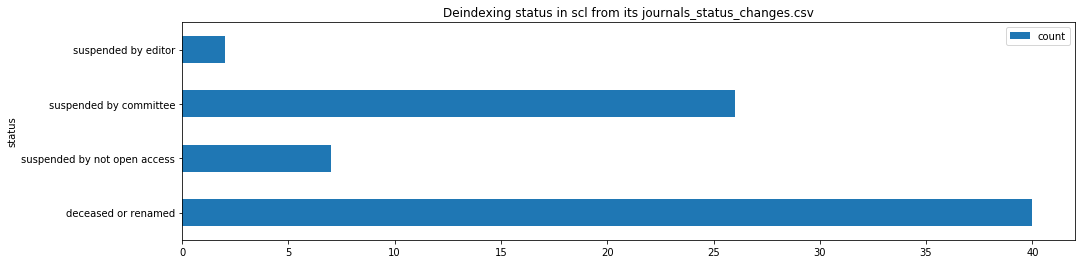

In [23]:
status_from_csv = reasons_from_csv.assign(
    status=[reason.replace("not-", "suspended-by-not-")
                  .replace("-", " ")
            or current_status.replace("ed", "ed or renamed")
            for current_status, reason in reasons_from_csv.index.values
    ]
).set_index("status")
status_from_csv.drop("current").plot.barh(
    figsize=(16, 4),
    title="Deindexing status in scl from its journals_status_changes.csv"
)
status_from_csv

To segregate the *deceased* from *renamed*,
we need the information from ArticleMeta,
as had been done before in this notebook.
There's a missing *current* in this analysis
because we're using a 2018-06-10 snapshot here,
whereas the ArticleMeta data is loading the current data.